# IAVSAI

#### To start the project:

- First of all, you'll need Onyxia in order to create a new service and launch Vscode-python-gpu.
- Open the github project on it.
- Then, please add your Onyxia user's name in the variable below:


In [7]:
user_name = "linafarchado"

#### Now
- Run the following commands to install the dependencies
- After that, restart the kernel
- Then you can comment theses commands to not run them again

In [ ]:
! pip install nltk
! pip install datasets
! pip install spacy
! pip uninstall -y scipy
! pip install scipy==1.12
! pip install tensorflow

import nltk
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
import os
import s3fs
import zipfile

import numpy as np
import pandas as pd
import re
from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import word_tokenize          

from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate

### Export Dataset

In [ ]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

# List the challenge's files
fs.ls("civel/diffusion/hackathon-minarm-2024/AIVSAI")
PATH_IN = 'civel/diffusion/hackathon-minarm-2024/AIVSAI/hack_train.csv'
fs.download(PATH_IN, 'data/hack_train.csv')

In [4]:
def load_csv():
    file_path = "data/hack_train.csv"
    return pd.read_csv(filepath_or_buffer=file_path)
df = load_csv()
df

,text,label,src
0,Little disclaimer: this deals with US laws and...,1,cmv_human
1,"Read: Mentally Retarded Downs. See, we've got ...",1,cmv_human
2,"If any of you frequent rbadhistory, there is a...",1,cmv_human
3,"I believe in a flat tax system, where everyone...",1,cmv_human
4,"Edit: Ok guy's, my views have been changed on ...",1,cmv_human
...,...,...,...
56814,We consider the recovery of a source term f (x...,1,sci_gen_human
56815,"Self-supervised learning (SlfSL), aiming at le...",1,sci_gen_human
56816,Recurrent neural networks (RNNs) have achieved...,1,sci_gen_human
56817,Deep reinforcement learning (DRL) is a booming...,1,sci_gen_human


### Clean Dataframe

In [5]:
def clean_dataframe(df):
    df = df.drop_duplicates()
    df = df.dropna()
    
    return df
df = clean_dataframe(df)
df

,text,label,src
0,Little disclaimer: this deals with US laws and...,1,cmv_human
1,"Read: Mentally Retarded Downs. See, we've got ...",1,cmv_human
2,"If any of you frequent rbadhistory, there is a...",1,cmv_human
3,"I believe in a flat tax system, where everyone...",1,cmv_human
4,"Edit: Ok guy's, my views have been changed on ...",1,cmv_human
...,...,...,...
56814,We consider the recovery of a source term f (x...,1,sci_gen_human
56815,"Self-supervised learning (SlfSL), aiming at le...",1,sci_gen_human
56816,Recurrent neural networks (RNNs) have achieved...,1,sci_gen_human
56817,Deep reinforcement learning (DRL) is a booming...,1,sci_gen_human


### Save Dataset in Onyxia

- After running the next cell, you will be able to observe the dataset on Onyxia

In [8]:
PATH_OUT = user_name + '/diffusion/projet-mongroupe-hackathon/hack_train.csv'
with fs.open(PATH_OUT, 'w') as file_out:
    df.to_csv(file_out, index=False)

### Read From Onyxia

In [9]:
with fs.open(PATH_OUT, mode="r") as file_in:
    df = pd.read_csv(file_in)
    df = clean_dataframe(df)

In [9]:
df.head()

,text,label,src
0,Little disclaimer: this deals with US laws and...,1,cmv_human
1,"Read: Mentally Retarded Downs. See, we've got ...",1,cmv_human
2,"If any of you frequent rbadhistory, there is a...",1,cmv_human
3,"I believe in a flat tax system, where everyone...",1,cmv_human
4,"Edit: Ok guy's, my views have been changed on ...",1,cmv_human


### Statistiques

In [9]:
total_number_of_source = len(df['src'].drop_duplicates())
print("Total number of source:", total_number_of_source)

Total number of source: 322


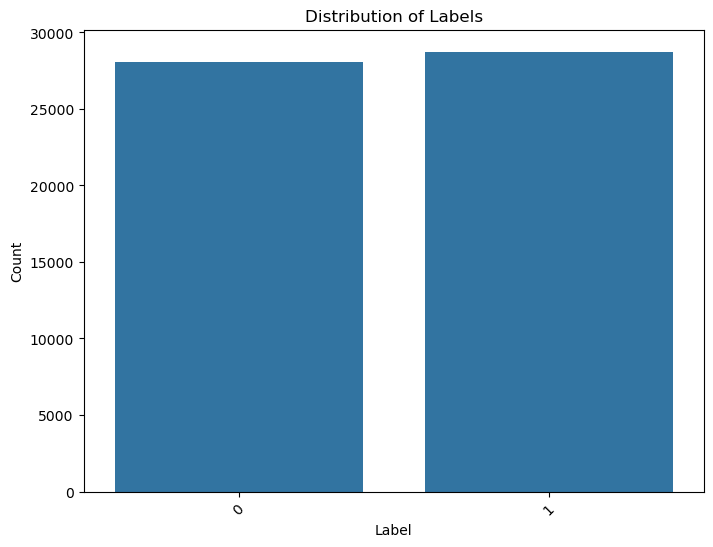

In [10]:
# Distribution of Labels
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

- Equal data distribution for classification is advantageous as it prevents bias, aids generalization, ensures fair evaluation, and enhances learning stability.

### Compare the length of the answers between human and machine

In [11]:
def compareLengthAnswer(data) :

    #Collect the length of the answer
    lengthHumanAnswer = data[data['label'] ==  1]['text'].apply(len)
    lengthChatGPTAnswer = data[data['label'] ==  0]['text'].apply(len)
    
    # Display the graphic
    plt.figure(figsize=(10, 6))
    plt.hist(lengthHumanAnswer, bins=100, alpha=0.5, label='Human Answers')
    plt.hist(lengthChatGPTAnswer, bins=20, alpha=0.5, label='Machine Answers')
    plt.title(' Comparaison: the length of the answers between human and machine')
    plt.xlabel('Number of caracters per response')
    plt.ylabel('Number of response')
    plt.legend()

    plt.yscale('log')
    plt.xlim(left=0)

    plt.grid(True)
    plt.show()

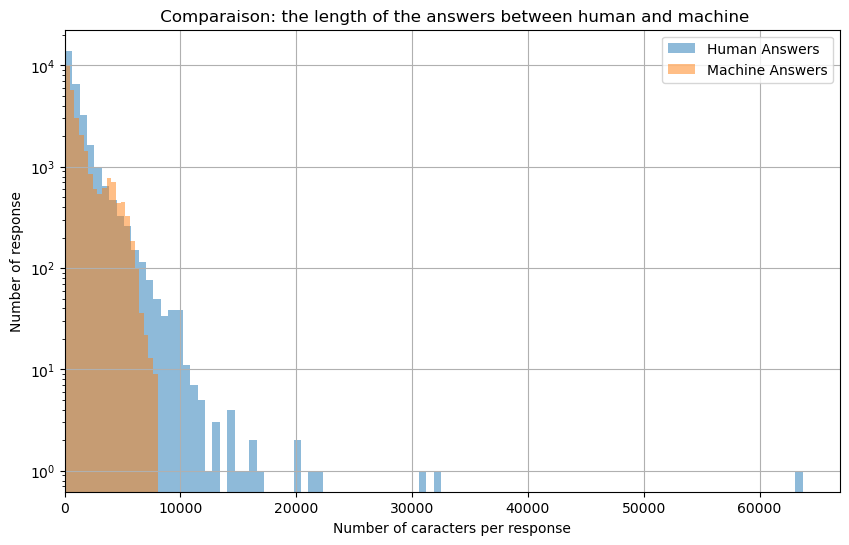

In [12]:
compareLengthAnswer(df)

- We can see that human answers are likely to be longer than machine answers
- Human answers tend to be longer because they include additional context and elaboration, aiming for comprehensive understanding.
- AI-generated responses prioritize brevity while still conveying essential information efficiently.

### Count number of sentences per source

In [13]:
def count_sentences(text):
    # Using regex to detect end of sentense more precisely
    sentences = re.split(r'(?<=[.!?])\s+', text)
    return len([sentence for sentence in sentences if sentence.strip()])

df_final = df.copy()
df_final['human_sentence_count'] = df_final[df_final['label'] ==  1]['text'].apply(count_sentences)
df_final['chatgpt_sentence_count'] = df_final[df_final['label'] ==  0]['text'].apply(count_sentences)

grouped = df_final.groupby('src').agg({
    'human_sentence_count': 'sum',
    'chatgpt_sentence_count': 'sum'
}).reset_index()

grouped

,src,human_sentence_count,chatgpt_sentence_count
0,cmv_human,38731.0,0.0
1,cmv_machine_continuation_13B,0.0,3259.0
2,cmv_machine_continuation_30B,0.0,2743.0
3,cmv_machine_continuation_65B,0.0,3087.0
4,cmv_machine_continuation_7B,0.0,3099.0
...,...,...,...
317,yelp_machine_continuation_opt_iml_max_1.3b,0.0,660.0
318,yelp_machine_continuation_t0_11b,0.0,129.0
319,yelp_machine_continuation_t0_3b,0.0,312.0
320,yelp_machine_continuation_text-davinci-002,0.0,1185.0


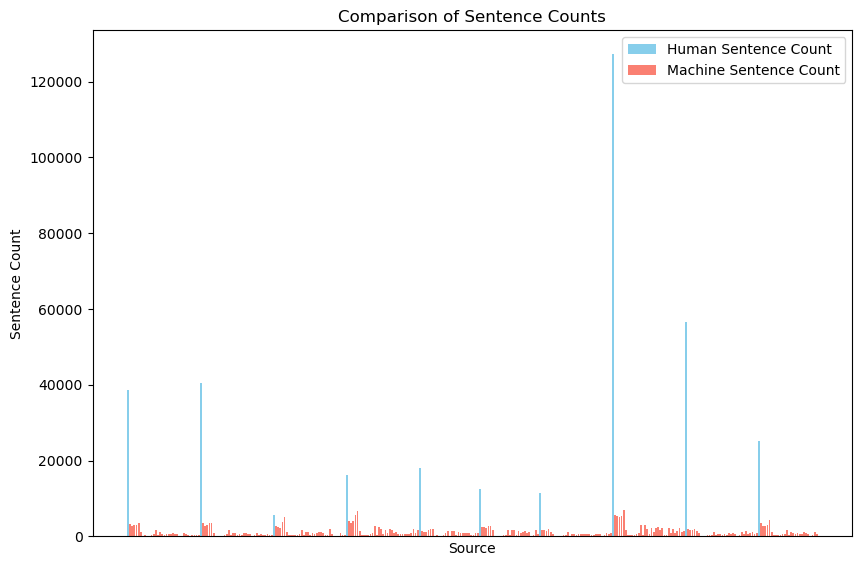

In [14]:
plt.figure(figsize=(10, 6))
plt.bar(grouped['src'], grouped['human_sentence_count'], color='skyblue', label='Human Sentence Count')
plt.bar(grouped['src'], grouped['chatgpt_sentence_count'], color='salmon', label='Machine Sentence Count')
plt.ylabel('Sentence Count')
plt.xlabel('Source')
plt.title('Comparison of Sentence Counts')
plt.legend()
plt.tight_layout()
plt.xticks([])
plt.show()

## Models

## Naive Bayes (nb)

Data

In [12]:
dataset_nb = df.copy()
dataset_nb

,text,label,src
0,Little disclaimer: this deals with US laws and...,1,cmv_human
1,"Read: Mentally Retarded Downs. See, we've got ...",1,cmv_human
2,"If any of you frequent rbadhistory, there is a...",1,cmv_human
3,"I believe in a flat tax system, where everyone...",1,cmv_human
4,"Edit: Ok guy's, my views have been changed on ...",1,cmv_human
...,...,...,...
56814,We consider the recovery of a source term f (x...,1,sci_gen_human
56815,"Self-supervised learning (SlfSL), aiming at le...",1,sci_gen_human
56816,Recurrent neural networks (RNNs) have achieved...,1,sci_gen_human
56817,Deep reinforcement learning (DRL) is a booming...,1,sci_gen_human


In [13]:
X = dataset_nb['text']
Y = dataset_nb['label']

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Model

- In this section we are using a grid search for Naives Bayes.

In [ ]:
# Model construction with a tokenizer and ngram_range
model = make_pipeline(CountVectorizer(tokenizer=word_tokenize, ngram_range = (2,2)), MultinomialNB(alpha=5.0, fit_prior=False))

# Grid search for Naives Bayes

# Define the parameter grid
param_grid = {
    'multinomialnb__alpha': [1.0, 2.0, 3.0],        # Smoothing parameter
    'multinomialnb__fit_prior': [True, False]       # Whether to learn class prior probabilities
}
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, Y_train)

In [ ]:
# Redirecting output to a file

#gridsearch_nb_file = 'gridsearch_nb.txt'
#with open(gridsearch_nb_file, 'w') as f:
#    print("Best parameters:", grid_search.best_params_, file=f)
#    print("Best cross-validation score:", grid_search.best_score_, file=f)
#    best_model = grid_search.best_estimator_
#    test_score = best_model.score(X_lr_test, y_lr_test)
#    print("Test set score:", test_score, file=f)

In [16]:
model.fit(X_train, Y_train)

/opt/mamba/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(ngram_range=(2, 2),
                                 tokenizer=<function word_tokenize at 0x7f89a1ed99e0>)),
                ('multinomialnb', MultinomialNB(alpha=5.0, fit_prior=False))])

In [17]:
y_pred = model.predict(X_test)

In [18]:
classification_report_naive_bayes = classification_report(Y_test, y_pred)
print("Classification Report:\n", classification_report_naive_bayes)

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.97      0.81      5552
           1       0.96      0.59      0.73      5812

    accuracy                           0.78     11364
   macro avg       0.83      0.78      0.77     11364
weighted avg       0.83      0.78      0.77     11364



In [ ]:
# Write the classification report to the file
#file_path = 'classification_report_naive_bayes.txt'
#with open(file_path, 'w') as file:
#    file.write(classification_report_naive_bayes)

Confusion matrix

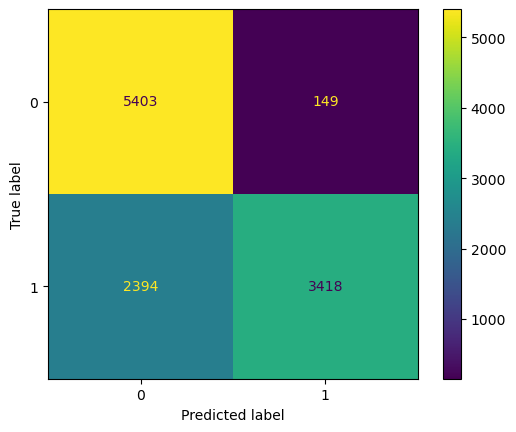

In [19]:
cm = confusion_matrix(Y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

Cross Validation

In [ ]:
# Perform cross-validation and print the mean accuracy
scoring = 'f1_macro'
scores = cross_val_score(model, X, Y, cv=5, scoring=scoring, n_jobs = -1)
print(f"Mean {scoring}: {scores.mean()}")
print(f"Standard deviation {scoring}: {scores.std()}")

scores_1 = cross_val_score(model, X, Y, cv=10, scoring=scoring, n_jobs = -1)
print(f"Mean {scoring}: {scores_1.mean()}")
print(f"Standard deviation {scoring}: {scores_1.std()}")

## CNN Model

Prepare data and create model

In [21]:
# Separate text and labels
texts = df['text'].values
labels = df['label'].values

# Tokenization & padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
MAX_LEN = 100

X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_LEN)

# Invert label mapping
label_mapping = {0: 1, 1: 0}

if all(label in [0, 1] for label in labels):
    label_mapping = {0: 1, 1: 0}

labels = np.array([label_mapping[label] for label in labels])

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Model
input_text = Input(shape=(MAX_LEN,), name='input_text')
embed = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128)(input_text)
conv = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(embed)
pool = GlobalMaxPooling1D()(conv)
dense1 = Dense(64, activation='relu')(pool)
output = Dense(1, activation='sigmoid')(dense1)
cnn_model = Model(inputs=input_text, outputs=output)

# Compile
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training
cnn_model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/15


2024-04-25 09:21:29.914894: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2436 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:17:00.0, compute capability: 8.6
I0000 00:00:1714036891.680400   16027 service.cc:145] XLA service 0x7f85380174e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714036891.680491   16027 service.cc:153]   StreamExecutor device (0): NVIDIA A2, Compute Capability 8.6
2024-04-25 09:21:31.723976: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-25 09:21:32.029252: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900


  10/1066 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.4539 - loss: 0.6999

I0000 00:00:1714036897.076477   16027 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1066/1066 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - accuracy: 0.6439 - loss: 0.6000 - val_accuracy: 0.8191 - val_loss: 0.3999
Epoch 2/15
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9471 - loss: 0.1566 - val_accuracy: 0.8374 - val_loss: 0.4006
Epoch 3/15
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9900 - loss: 0.0439 - val_accuracy: 0.8197 - val_loss: 0.5327
Epoch 4/15
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9924 - loss: 0.0303 - val_accuracy: 0.8280 - val_loss: 0.5045
Epoch 5/15
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9962 - loss: 0.0179 - val_accuracy: 0.8286 - val_loss: 0.5561
Epoch 6/15
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9962 - loss: 0.0168 - val_accuracy: 0.8262 - val_loss: 0.5564
Epoch 7/15
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9978 - loss: 0.0084 - val_accuracy: 0.8185 - val_loss: 0.6625
Epoch 8/15
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9981 - loss: 0.00

Evaluation and prediction

In [22]:
# Evaluation
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Predict labels on test data
y_pred = (cnn_model.predict(X_test) > 0.5).astype("int32")

# Generate and print the classification report
print("Classification Report for CNN Model:")
classification_report_cnn = classification_report(y_test, y_pred)
print(classification_report_cnn)

# Calculate precision, recall and F1 score for both classes.
precision_class_0 = precision_score(y_test, y_pred, pos_label=0)
recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
f1_class_0 = f1_score(y_test, y_pred, pos_label=0)

precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
f1_class_1 = f1_score(y_test, y_pred, pos_label=1)

print("Metrics for class 0:")
print("Precision:", precision_class_0)
print("Recall:", recall_class_0)
print("F1-score:", f1_class_0)

print("\nMetrics for class 1:")
print("Precision:", precision_class_1)
print("Recall:", recall_class_1)
print("F1-score:", f1_class_1)

356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8108 - loss: 1.0720
Test Accuracy: 81.48%
356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Classification Report for CNN Model:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81      5812
           1       0.78      0.86      0.82      5552

    accuracy                           0.81     11364
   macro avg       0.82      0.82      0.81     11364
weighted avg       0.82      0.81      0.81     11364

Metrics for class 0:
Precision: 0.849255700018843
Recall: 0.7754645560908465
F1-score: 0.8106844140660131

Metrics for class 1:
Precision: 0.7845468053491828
Recall: 0.8559077809798271
F1-score: 0.8186751658196227


In [23]:
# Write the classification report to the file
#file_path = 'classification_report_CNN.txt'
#with open(file_path, 'w') as file:
#    file.write(classification_report_cnn)

Confusion Matrix

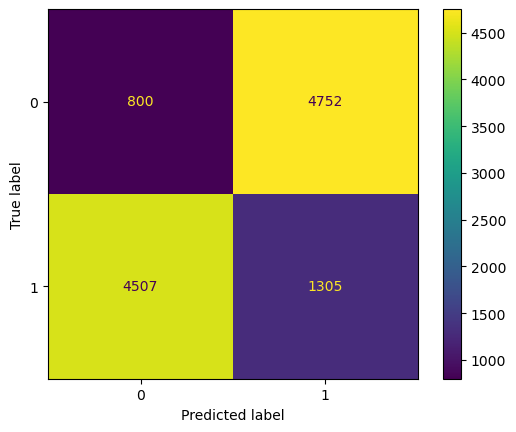

In [24]:
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

## Transformer from scratch

Prepare data and create model

In [25]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense, Dropout, Flatten

# Separate text and labels
texts = df['text'].values
labels = df['label'].values

# Tokenization & padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
MAX_LEN = 100
X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_LEN)
y = labels

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Reshape input data
X_train = X_train.reshape(X_train.shape[0], MAX_LEN)
X_val = X_val.reshape(X_val.shape[0], MAX_LEN)
X_test = X_test.reshape(X_test.shape[0], MAX_LEN)

# Transformer Model
vocab_size = len(tokenizer.word_index) + 1
max_len = MAX_LEN

input_layer = Input(shape=(max_len,), name='transformer_input')
embed = Embedding(vocab_size, 128, mask_zero=True)(input_layer)
attention = MultiHeadAttention(num_heads=8, key_dim=64)(embed, embed)
attention = LayerNormalization()(attention + embed)
dense = Dense(64, activation='relu')(attention)
dropout = Dropout(0.1)(dense)
output = Dense(64, activation='relu')(dropout)
output = Flatten()(output)
output = Dense(1, activation='sigmoid')(output)

transformer_model = Model(inputs=input_layer, outputs=output)

# Compile Transformer model
transformer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Transformer model
transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20


/opt/mamba/lib/python3.11/site-packages/keras/src/layers/layer.py:873: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/keras/src/layers/layer.py:873: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/keras/src/layers/layer.py:873: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
I0000 00:00:1714037363.319221   22089 asm_

1064/1066 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6122 - loss: 0.6359

I0000 00:00:1714037403.135848   22347 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_46', 248 bytes spill stores, 248 bytes spill loads

I0000 00:00:1714037403.222721   22339 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_46', 12 bytes spill stores, 16 bytes spill loads

I0000 00:00:1714037403.727484   22264 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_48', 272 bytes spill stores, 272 bytes spill loads

I0000 00:00:1714037404.029280   22272 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_48', 152 bytes spill stores, 148 bytes spill loads



1066/1066 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6124 - loss: 0.6357

I0000 00:00:1714037411.925786   22658 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1714037418.335500   22729 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1714037418.342514   22794 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_9', 248 bytes spill stores, 248 bytes spill loads

I0000 00:00:1714037418.628546   22784 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_9', 12 bytes spill stores, 16 bytes spill loads



1066/1066 ━━━━━━━━━━━━━━━━━━━━ 65s 48ms/step - accuracy: 0.6125 - loss: 0.6356 - val_accuracy: 0.8103 - val_loss: 0.4212
Epoch 2/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.8935 - loss: 0.2679 - val_accuracy: 0.8253 - val_loss: 0.4368
Epoch 3/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.9633 - loss: 0.0973 - val_accuracy: 0.8306 - val_loss: 0.4402
Epoch 4/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.9806 - loss: 0.0520 - val_accuracy: 0.8332 - val_loss: 0.6921
Epoch 5/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 32s 30ms/step - accuracy: 0.9864 - loss: 0.0385 - val_accuracy: 0.8258 - val_loss: 0.7575
Epoch 6/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.9903 - loss: 0.0281 - val_accuracy: 0.8244 - val_loss: 0.7406
Epoch 7/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.9921 - loss: 0.0228 - val_accuracy: 0.8314 - val_loss: 0.8405
Epoch 8/20
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.9936 - loss: 0.01

Evaluation and prediction

In [26]:
# Evaluate Transformer model
loss, accuracy = transformer_model.evaluate(X_test, y_test)
print(f'Transformer Test Accuracy: {accuracy * 100:.2f}%')

# Predict labels on test data
y_pred = (transformer_model.predict(X_test) > 0.5).astype("int32")

# Generate and print the classification report
print("Classification Report for Transformer Model:")
classification_report_transformer = classification_report(y_test, y_pred)
print(classification_report_transformer)

# Calculate precision, recall and F1 score for both classes.
precision_class_0 = precision_score(y_test, y_pred, pos_label=0)
recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
f1_class_0 = f1_score(y_test, y_pred, pos_label=0)

precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
recall_class_1 = recall_score(y_test, y_pred, pos_label=1)
f1_class_1 = f1_score(y_test, y_pred, pos_label=1)

print("Metrics for class 0:")
print("Precision:", precision_class_0)
print("Recall:", recall_class_0)
print("F1-score:", f1_class_0)

print("\nMetrics for class 1:")
print("Precision:", precision_class_1)
print("Recall:", recall_class_1)
print("F1-score:", f1_class_1)

356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8222 - loss: 1.4369
Transformer Test Accuracy: 82.24%
356/356 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
Classification Report for Transformer Model:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      5552
           1       0.84      0.80      0.82      5812

    accuracy                           0.82     11364
   macro avg       0.82      0.82      0.82     11364
weighted avg       0.82      0.82      0.82     11364

Metrics for class 0:
Precision: 0.802672147995889
Recall: 0.8440201729106628
F1-score: 0.8228270412642669

Metrics for class 1:
Precision: 0.8432862830256967
Recall: 0.8017894012388163
F1-score: 0.8220144646322103


In [27]:
# Write the classification report to the file
#file_path = 'classification_report_transformer_from_scratch.txt'
#with open(file_path, 'w') as file:
#    file.write(classification_report_transformer)

Confusion Matrix

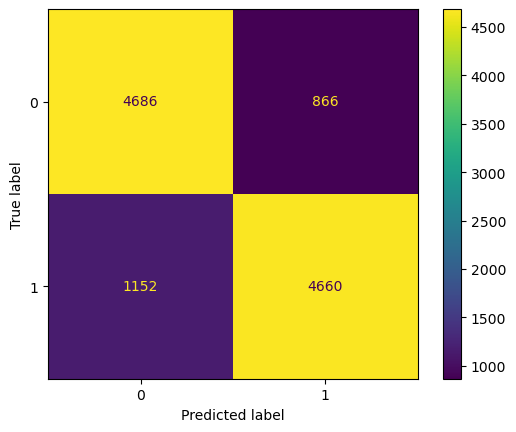

In [28]:
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

## Linear regression (lr)

Data

In [10]:
df_lr = df

X_lr = df_lr['text']
y_lr = df_lr['label']

X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X_lr, y_lr, test_size=0.2, random_state=42)

text_transformer = CountVectorizer()

X_lr_train_vectorized = text_transformer.fit_transform(X_lr_train)
X_lr_test_vectorized = text_transformer.transform(X_lr_test)

Model

In [12]:
model_lr = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
model_lr.fit(X_lr_train_vectorized, y_lr_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

Analysis

In [13]:
y_lr_pred = model_lr.predict(X_lr_test_vectorized)
test_accuracy_lr = accuracy_score(y_lr_test, y_lr_pred)
classification_report_lr = classification_report(y_lr_test, y_lr_pred)
print("Classification Report:\n", classification_report_lr)
print("Testing Accuracy:", test_accuracy_lr)

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.87      5552
           1       0.89      0.86      0.87      5812

    accuracy                           0.87     11364
   macro avg       0.87      0.87      0.87     11364
weighted avg       0.87      0.87      0.87     11364

Testing Accuracy: 0.8738120380147836


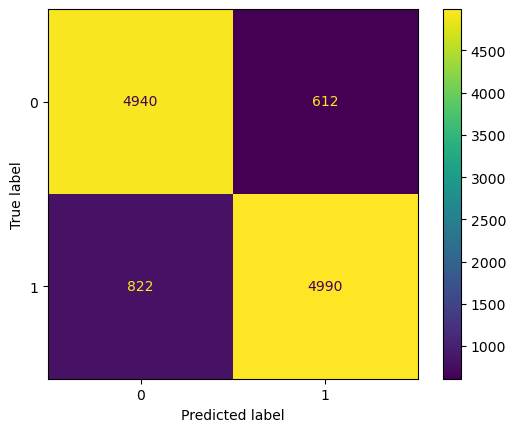

In [14]:
cm = confusion_matrix(y_lr_test, y_lr_pred, labels=model_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_lr.classes_)
disp.plot()
plt.show()

This confusion matrix evaluates our model's performance:

- True Negative (TN): 4940
- False Positive (FP): 612
- False Negative (FN): 823
- True Positive (TP): 4989

And there is still room for improvement. We can now use a grid search to get the best parameters for our model.
You can skip this cell, and print the results in the next one

In [ ]:
model = make_pipeline(CountVectorizer(), LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'))

param_grid = {
    'countvectorizer__lowercase': [False, True],
    'countvectorizer__tokenizer': [word_tokenize],
    'countvectorizer__ngram_range': [(1, 1), (2, 2)],
    'countvectorizer__stop_words': [None, 'english'],
    'logisticregression__C': [0.001, 0.01, 0.1],
    'logisticregression__penalty': ['l1', 'l2'],
}
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_lr_train, y_lr_train)
best_model = grid_search.best_estimator_

In [15]:
gridsearch_lr_file = 'gridsearch_lr.txt'
# Redirecting output to a file

#with open('gridsearch_lr.txt', 'w') as f:
#    print("Best parameters:", grid_search.best_params_, file=f)
#    print("Best cross-validation score:", grid_search.best_score_, file=f)
#    best_model = grid_search.best_estimator_
#    test_score = best_model.score(X_lr_test, y_lr_test)
#    print("Test set score:", test_score, file=f)

with open(gridsearch_lr_file, 'r') as file:
    gridsearch_contents = file.read()
print(gridsearch_contents)


Best parameters: {'countvectorizer__lowercase': False, 'countvectorizer__ngram_range': (2, 2), 'countvectorizer__stop_words': None, 'countvectorizer__tokenizer': <function word_tokenize at 0x7f5291df3240>, 'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}
Best cross-validation score: 0.9296275324657092
Test set score: 0.9425378387891588



In [16]:
# Saving the model
#dump(best_model, 'trained_model_lr.joblib')
best_model = load('trained_model_lr.joblib')

In [17]:
y_lr_pred = best_model.predict(X_lr_test)
classification_report_lr = classification_report(y_lr_test, y_lr_pred)
print("Classification Report:\n", classification_report_lr)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      5552
           1       0.93      0.96      0.94      5812

    accuracy                           0.94     11364
   macro avg       0.94      0.94      0.94     11364
weighted avg       0.94      0.94      0.94     11364



In [ ]:
#Write the classification report to the file
#file_path = 'classification_report_logistic_regression.txt'
#with open(file_path, 'w') as file:
#    file.write(classification_report_lr)